In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [168]:
#reading the dataset
df=pd.read_csv("Information.csv",engine="python")
df.shape

(20050, 26)

In [169]:
# Drop unnecessary columns/features
df.drop (columns = ['_unit_id',
                      '_last_judgment_at',
                      'user_timezone',
                      'tweet_coord',
                      'tweet_count',
                      'tweet_created', 
                      'tweet_id',
                      'tweet_location',
                      'profileimage',
                      'created'], inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _golden                20050 non-null  bool   
 1   _unit_state            20050 non-null  object 
 2   _trusted_judgments     20050 non-null  int64  
 3   gender                 19953 non-null  object 
 4   gender:confidence      20024 non-null  float64
 5   profile_yn             20050 non-null  object 
 6   profile_yn:confidence  20050 non-null  float64
 7   description            16306 non-null  object 
 8   fav_number             20050 non-null  int64  
 9   gender_gold            50 non-null     object 
 10  link_color             20050 non-null  object 
 11  name                   20050 non-null  object 
 12  profile_yn_gold        50 non-null     object 
 13  retweet_count          20050 non-null  int64  
 14  sidebar_color          20050 non-null  object 
 15  te

In [170]:
df.head()

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,gender_gold,link_color,name,profile_yn_gold,retweet_count,sidebar_color,text
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,1,C0DEED,i absolutely adore when louis starts the songs...
3,False,finalized,3,male,1.0000,yes,1.0,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...
4,False,finalized,3,female,1.0000,yes,1.0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,0,0,Watching Neighbours on Sky+ catching up with t...


In [171]:
df['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [172]:
#we should remove the rows with unknown gender
drop_items_idx = df[df['gender'] == 'unknown'].index
df.drop (index = drop_items_idx, inplace = True)
df['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

In [173]:
print ('profile_yn information:\n',df['profile_yn'].value_counts())

df[df['profile_yn'] == 'no']['gender']


profile_yn information:
 yes    18836
no        97
Name: profile_yn, dtype: int64


109      NaN
137      NaN
496      NaN
582      NaN
679      NaN
        ... 
18524    NaN
18700    NaN
18840    NaN
19773    NaN
19842    NaN
Name: gender, Length: 97, dtype: object

In [174]:
drop_items_idx = df[df['profile_yn'] == 'no'].index

df.drop (index = drop_items_idx, inplace = True)

print (df['profile_yn'].value_counts())

df.drop (columns = ['profile_yn','profile_yn:confidence','profile_yn_gold'], inplace = True)

yes    18836
Name: profile_yn, dtype: int64


In [175]:
print ('Full data items: ', df.shape)
#remoce rows with confidence less than 100%
print ('Data with label-confidence < 100%: ', df[df['gender:confidence'] < 1].shape)

Full data items:  (18836, 13)
Data with label-confidence < 100%:  (5032, 13)


In [176]:
drop_items_idx = df[df['gender:confidence'] < 1].index

df.drop (index = drop_items_idx, inplace = True)
print (df['gender:confidence'].value_counts())


1.0    13804
Name: gender:confidence, dtype: int64


In [177]:
df.head(2)

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,description,fav_number,gender_gold,link_color,name,retweet_count,sidebar_color,text
0,False,finalized,3,male,1.0,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,False,finalized,3,male,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...


In [178]:
import re
def normalize_text(s):
    s = str(s)
    s = s.lower()
    s = re.sub('[^\x00-\x7F]+',' ',s)
    
    # Remove URLs
    s= re.sub('https?:\/\/.*[\r\n]*', ' ',s)
    
    # Remove special chars.
    s= re.sub('[?!+%{}:;.,"\'()\[\]_]', '',s)
    
    # Remove double spaces.
    s= re.sub('\s+',' ',s)
    
   
    
    return s

df['text_norm'] = [normalize_text(s) for s in df['text']]
#df['description_norm'] = [normalize_text(s) for s in df['description']]

In [179]:
df_confident = df[df['gender:confidence']==1]
df_confident.shape

(13804, 14)

In [180]:
#remove stopwords and split the data into words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
df_confident['text_norm'] = df_confident['text_norm'].astype(str).str.lower().str.split()
df_confident['text_norm'] = df_confident['text_norm'].apply(lambda x : [item for item in x if item not in stop])
df_confident.head()

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,description,fav_number,gender_gold,link_color,name,retweet_count,sidebar_color,text,text_norm
0,False,finalized,3,male,1.0,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,"[robbie, e, responds, critics, win, eddie, edw..."
1,False,finalized,3,male,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...,"[felt, like, friends, living, story]"
3,False,finalized,3,male,1.0,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,"[hi, @jordanspieth, -, looking, url, -, use, @..."
4,False,finalized,3,female,1.0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,0,0,Watching Neighbours on Sky+ catching up with t...,"[watching, neighbours, sky, catching, neighbs,..."
5,False,finalized,3,female,1.0,you don't know me.,3901,NaN,F5ABB5,monroevicious,0,0,"Ive seen people on the train with lamps, chair...","[ive, seen, people, train, lamps, chairs, tvs,..."


In [181]:
#counting the frequency of words user by males, females and brands
Male = df_confident[df_confident['gender'] == 'male']
Female = df_confident[df_confident['gender'] == 'female']
Brand = df_confident[df_confident['gender'] == 'brand']
Male_Words = pd.Series(' '.join(Male['text_norm'].astype(str)).lower().split(" ")).value_counts()[:10]
Female_Words = pd.Series(' '.join(Female['text_norm'].astype(str)).lower().split(" ")).value_counts()[:10]
Brand_words = pd.Series(' '.join(Brand['text_norm'].astype(str)).lower().split(" ")).value_counts()[:10]


'im',      408
'like',    309
'get',     267
'one',     208
'day',     200
dtype: int64

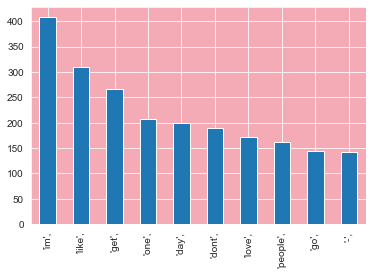

In [182]:
Female_Words.plot(kind='bar',stacked=True)
Female_Words.head()

'like',    242
'get',     227
'im',      221
'-',       202
'dont',    166
dtype: int64

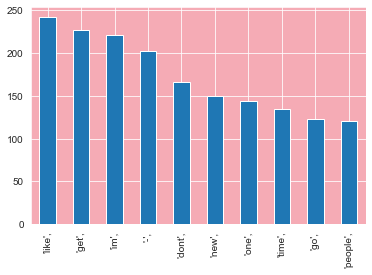

In [183]:
Male_Words.plot(kind='bar',stacked=True)
Male_Words.head()

'weather',    1078
['get',        553
'updates',     541
'channel',     539
'-',           270
dtype: int64

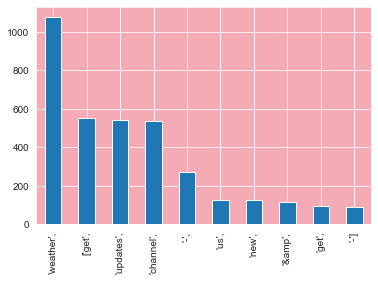

In [184]:
Brand_words.plot(kind='bar',stacked=True)
Brand_words.head()

In [185]:
#most common words without removing stopwords
from collections import Counter

twit_vocab = Counter()
for twit in df['text']:
    for word in twit.split(' '):
        twit_vocab[word] += 1
        
twit_vocab.most_common(20)

[('the', 8370),
 ('and', 7964),
 ('to', 4196),
 ('I', 3229),
 ('a', 3064),
 ('of', 2741),
 ('in', 2270),
 ('you', 2173),
 ('for', 2157),
 ('The', 2018),
 ('is', 1878),
 ('on', 1621),
 ('my', 1362),
 ('it', 1205),
 ('', 1184),
 ('with', 1156),
 ('Weather', 1074),
 ('that', 1032),
 ('from', 1022),
 ('me', 1001)]

In [186]:
#most common words after removing stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

twit_vocab_reduced = Counter()
for w, c in twit_vocab.items():
    if not w in stop:
        twit_vocab_reduced[w]=c

twit_vocab_reduced.most_common(20)

[('I', 3229),
 ('The', 2018),
 ('', 1184),
 ('Weather', 1074),
 ('-', 767),
 ("I'm", 651),
 ('like', 628),
 ('Get', 627),
 ('get', 570),
 ('Updates', 538),
 ('Channel.', 537),
 ('And', 487),
 ('one', 416),
 ('&amp;', 348),
 ('new', 343),
 ('love', 340),
 ('people', 315),
 ('time', 301),
 ('go', 290),
 ('know', 288)]

In [187]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

In [188]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


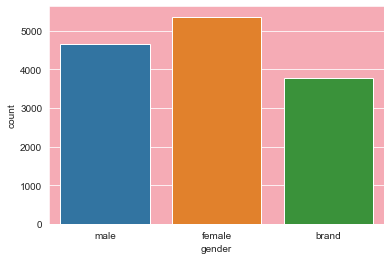

In [189]:
#plot the count of each gender
sns.countplot(df['gender'],label="Gender")

['0084B4' '009999' '3B94D9' '2FC2EF' 'DD2E44' '000000' 'ABB8C2']


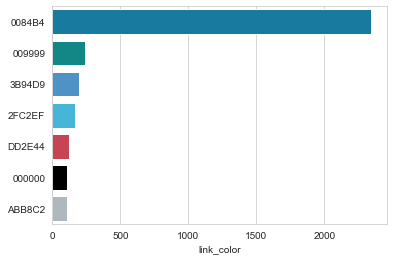

In [190]:
#plot the top link colour of each gender
male_top_link_color = df[df['gender'] == 'male']['link_color'].value_counts().head(7)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values
male_top_color[1] = '009999'
male_top_color[5] = '000000'
print(male_top_color)

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = male_top_link_color, y = male_top_link_color_idx, palette=list(map(l, male_top_color)))

['0084B4' '9266CC' 'F5ABB5' 'DD2E44' 'FF0000' '3B94D9' 'ABB8C2']


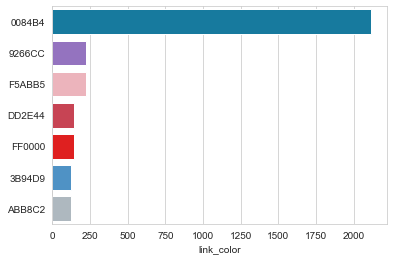

In [191]:
female_top_link_color = df[df['gender'] == 'female']['link_color'].value_counts().head(7)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values
print(female_top_color)
l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = female_top_link_color, y = female_top_link_color_idx, palette=list(map(l, female_top_color)))

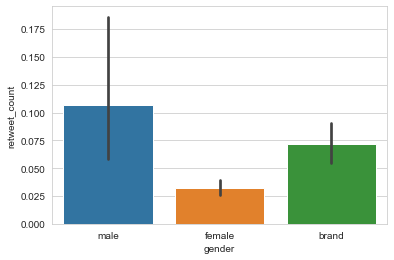

In [192]:
#bar plot of retweet count by each gender
sns.barplot (x = 'gender', y = 'retweet_count',data = df)

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '181A1E' 'A8C7F7' '5ED4DC']


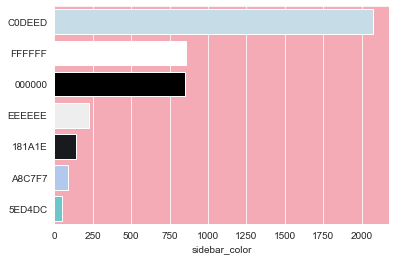

In [193]:
#top side colour plot for male and female
male_top_sidebar_color = df[df['gender'] == 'male']['sidebar_color'].value_counts().head(7)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[2] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color, palette=list(map(l, male_top_color)))

In [194]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(df['gender'])

# split the dataset in train and test
X = df['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train.head()

19087    @rvpisarapist my players literally give 110% a...
11212    Backers of the atrium lobby considered joining...
14799    I was supposed to receive my @SpiritHalloween ...
6846     Depression comes when you least expect it, lik...
1226     Grimes Throws a Fun, Bloody Party in "Flesh Wi...
Name: text, dtype: object

In [195]:
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by Logistic Regression:',accuracy_score(y_test,predictions))


Accuracy by Logistic Regression: 0.6001931434089812


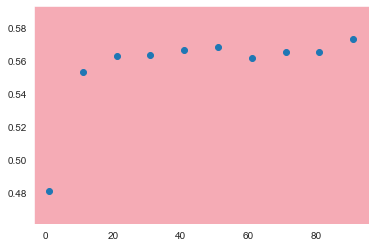

In [196]:
from sklearn.ensemble import RandomForestClassifier

n = range (1,100,10)

results = []
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()
plt.scatter(n, results)

In [197]:
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 40, random_state=42))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by Random Forest CLassification:',accuracy_score(y_test,predictions))

Accuracy by Random Forest CLassification: 0.5676001931434089


In [198]:
# the SVM model
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by SVM:',accuracy_score(y_test,predictions))

Accuracy by SVM: 0.5982617093191694


In [199]:
#Fill NaN with empty string
df.fillna("", inplace = True)

# Concatenate text with description, add white space between. 
# By using Series helper functions Series.str()
df['text_description'] = df['text'].str.cat(df['description'], sep=' ')

df['text_description'].isnull().value_counts() # Check if any null values, True if there is at least one.

False    13804
Name: text_description, dtype: int64

In [200]:
# split the dataset in train and test
X = df['text_description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_train.head()

19087    @rvpisarapist my players literally give 110% a...
11212    Backers of the atrium lobby considered joining...
14799    I was supposed to receive my @SpiritHalloween ...
6846     Depression comes when you least expect it, lik...
1226     Grimes Throws a Fun, Bloody Party in "Flesh Wi...
Name: text_description, dtype: object

In [201]:
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by Logistic Regression:',accuracy_score(y_test,predictions))

Accuracy by Logistic Regression: 0.6815548044422984


In [202]:
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 80, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by Random Forest Classification:',accuracy_score(y_test,predictions))

Accuracy by Random Forest Classification: 0.6448575567358764


In [203]:
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy by SVM:',accuracy_score(y_test,predictions))

Accuracy by SVM: 0.6868662481892805


In [204]:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(multi_class='ovr', random_state=42)
clf2 = RandomForestClassifier(n_estimators = 80, random_state=42)
clf3 = SVC(kernel = 'linear',probability = True, random_state=42)

ensemble_clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')

clf = Pipeline([('vect', tfidf),
                ('clf', ensemble_clf)])

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print('Accuracy after ensemble modelling:',accuracy_score(y_test,predictions))

Accuracy after ensemble modelling: 0.6897633993239981
